In [2]:
import os 
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


print("Tensorflow version:", tf.__version__)

2026-01-29 23:40:34.075781: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow version: 2.20.0


In [3]:
# Paths

script_dir =  Path.cwd()  # scripts
project_root = os.path.dirname(script_dir)  # PetImages
data_dir = os.path.join(project_root, 'splitted') # splitted
model_save_dir = os.path.join(project_root, 'models')
os.makedirs(model_save_dir, exist_ok=True)



In [4]:
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
NUM_CLASSES = 3


In [5]:
CLASS_NAMES = ['Cat_resized', 'Dog_resized', 'Parrot_resized']



In [6]:
# Data Loaders with Augmentation

In [7]:
print("Creating Data Loaders -> ")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # randomly + or - 20 degrees
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)


print(f"Training smaples: {train_generator.samples}")
print(f"Validation smaples: {train_generator.samples}")
print(f"Training smaples: {train_generator.samples}")


Creating Data Loaders -> 
Found 1050 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Found 226 images belonging to 3 classes.
Training smaples: 1050
Validation smaples: 1050
Training smaples: 1050


In [9]:
model = keras.Sequential([

    # Input layer
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Convolutional Block 4
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')  # Output: 3 classes

    
])

model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)




Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,618,179 (17.62 MB)

 Trainable params: 4,617,219 (17.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [10]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint_path = os.path.join(model_save_dir, 'best_model.h5')
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stop, checkpoint, reduce_lr]

In [11]:
# Training

start_time = datetime.now()

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

end_time = datetime.now()
training_duration = end_time - start_time

print(f"Training done in {training_duration} ")

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4461 - loss: 3.6638  
Epoch 1: val_accuracy improved from None to 0.37778, saving model to /home/gio/Documents/machine_learning/animal_classifier/PetImages/models/best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.4810 - loss: 3.5507 - val_accuracy: 0.3778 - val_loss: 1.9747 - learning_rate: 0.0010
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5017 - loss: 2.7523    
Epoch 2: val_accuracy did not improve from 0.37778
33/33 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5143 - loss: 2.5248 - val_accuracy: 0.3378 - val_loss: 1.7742 - learning_rate: 0.0010
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5404 - loss: 2.2305 
Epoch 3: val_accuracy did not improve from 0.37778
33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.5267 - loss: 2.1479 - val_accuracy: 0.3467 - val_loss: 2.4308 - learning_rate: 0.0010
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5058 - loss: 1.9255    
Epoch 4: val_accuracy did not improve from 0.37778
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5286 - loss: 1.8017 - val_accuracy: 0.3422 - val_loss: 2.4910 - learning_rate: 0.0010
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━

33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.5590 - loss: 1.3414 - val_accuracy: 0.4178 - val_loss: 1.2369 - learning_rate: 0.0010
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5356 - loss: 1.2053 
Epoch 8: val_accuracy did not improve from 0.41778
33/33 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5476 - loss: 1.1021 - val_accuracy: 0.3778 - val_loss: 1.3550 - learning_rate: 0.0010
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5412 - loss: 1.3058 
Epoch 9: val_accuracy did not improve from 0.41778
33/33 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5724 - loss: 1.1168 - val_accuracy: 0.3689 - val_loss: 1.4199 - learning_rate: 0.0010
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6010 - loss: 0.8854  
Epoch 10: val_accuracy did not improve from 0.41778
33/33 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.5676 - loss: 0.9701 - val_accuracy: 0.3600 - val_loss: 1.2701 - learning_rate: 0.0010
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━

33/33 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5629 - loss: 0.9126 - val_accuracy: 0.4711 - val_loss: 1.1087 - learning_rate: 0.0010
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5373 - loss: 0.9555  
Epoch 12: val_accuracy improved from 0.47111 to 0.49333, saving model to /home/gio/Documents/machine_learning/animal_classifier/PetImages/models/best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.5362 - loss: 0.9639 - val_accuracy: 0.4933 - val_loss: 1.0663 - learning_rate: 0.0010
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5211 - loss: 0.9287  
Epoch 13: val_accuracy did not improve from 0.49333
33/33 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5533 - loss: 0.8982 - val_accuracy: 0.4622 - val_loss: 1.0327 - learning_rate: 0.0010
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5802 - loss: 0.8260  
Epoch 14: val_accuracy improved from 0.49333 to 0.55111, saving model to /home/gio/Documents/machine_learning/animal_classifier/PetImages/models/best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5914 - loss: 0.8236 - val_accuracy: 0.5511 - val_loss: 0.9920 - learning_rate: 0.0010
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5878 - loss: 0.8786  
Epoch 15: val_accuracy improved from 0.55111 to 0.57778, saving model to /home/gio/Documents/machine_learning/animal_classifier/PetImages/models/best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5962 - loss: 0.8325 - val_accuracy: 0.5778 - val_loss: 0.8350 - learning_rate: 0.0010
Epoch 16/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5922 - loss: 0.8136  
Epoch 16: val_accuracy did not improve from 0.57778
33/33 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.5867 - loss: 0.8190 - val_accuracy: 0.4622 - val_loss: 1.0889 - learning_rate: 0.0010
Epoch 17/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5882 - loss: 0.7807  
Epoch 17: val_accuracy did not improve from 0.57778
33/33 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5648 - loss: 0.8137 - val_accuracy: 0.4800 - val_loss: 0.9965 - learning_rate: 0.0010
Epoch 18/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5652 - loss: 0.8043 
Epoch 18: val_accuracy did not improve from 0.57778
33/33 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5743 - loss: 0.8799 - val_accuracy: 0.4844 - val_loss: 1.1183 - learning_rate: 0.0010
Epoch 19/50
33/33 ━━━━━━━━━━━━━

33/33 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6124 - loss: 0.7278 - val_accuracy: 0.6311 - val_loss: 0.7806 - learning_rate: 5.0000e-04
Epoch 23/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6536 - loss: 0.6788 
Epoch 23: val_accuracy improved from 0.63111 to 0.66222, saving model to /home/gio/Documents/machine_learning/animal_classifier/PetImages/models/best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6324 - loss: 0.7313 - val_accuracy: 0.6622 - val_loss: 0.7314 - learning_rate: 5.0000e-04
Epoch 24/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6190 - loss: 0.7300 
Epoch 24: val_accuracy did not improve from 0.66222
33/33 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6314 - loss: 0.7674 - val_accuracy: 0.5822 - val_loss: 0.8829 - learning_rate: 5.0000e-04
Epoch 25/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6115 - loss: 0.7125 
Epoch 25: val_accuracy did not improve from 0.66222
33/33 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.6086 - loss: 0.7148 - val_accuracy: 0.6578 - val_loss: 0.8399 - learning_rate: 5.0000e-04
Epoch 26/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6166 - loss: 0.7798 
Epoch 26: val_accuracy did not improve from 0.66222
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6276 - loss: 0.7646 - val_accuracy: 0.6311 - val_loss: 0.8298 - learning_rate: 5.0000e-04
Epoch 27/50
33/33

33/33 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.6486 - loss: 0.6672 - val_accuracy: 0.6711 - val_loss: 0.7839 - learning_rate: 2.5000e-04
Epoch 31/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6660 - loss: 0.6776  
Epoch 31: val_accuracy did not improve from 0.67111
33/33 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6714 - loss: 0.7056 - val_accuracy: 0.6711 - val_loss: 0.7325 - learning_rate: 2.5000e-04
Epoch 32/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6799 - loss: 0.6533  
Epoch 32: val_accuracy improved from 0.67111 to 0.69333, saving model to /home/gio/Documents/machine_learning/animal_classifier/PetImages/models/best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6667 - loss: 0.6536 - val_accuracy: 0.6933 - val_loss: 0.7144 - learning_rate: 2.5000e-04
Epoch 33/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7098 - loss: 0.6339    
Epoch 33: val_accuracy did not improve from 0.69333
33/33 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.6924 - loss: 0.6462 - val_accuracy: 0.6889 - val_loss: 0.7329 - learning_rate: 2.5000e-04
Epoch 34/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6615 - loss: 0.6632   
Epoch 34: val_accuracy did not improve from 0.69333
33/33 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6638 - loss: 0.6649 - val_accuracy: 0.6844 - val_loss: 0.7746 - learning_rate: 2.5000e-04
Epoch 35/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6748 - loss: 0.6219 
Epoch 35: val_accuracy did not improve from 0.69333
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6752 - loss: 0.6342 - val_accuracy: 0.6756 - val_loss: 0.6770 - learning_rate: 2.5000e-04
Epoch 36/50


33/33 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6848 - loss: 0.6224 - val_accuracy: 0.7111 - val_loss: 0.7339 - learning_rate: 2.5000e-04
Epoch 37/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6693 - loss: 0.6270 
Epoch 37: val_accuracy did not improve from 0.71111
33/33 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6771 - loss: 0.6376 - val_accuracy: 0.6578 - val_loss: 0.7591 - learning_rate: 2.5000e-04
Epoch 38/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6627 - loss: 0.6709  
Epoch 38: val_accuracy did not improve from 0.71111
33/33 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6771 - loss: 0.6406 - val_accuracy: 0.6711 - val_loss: 0.6926 - learning_rate: 2.5000e-04
Epoch 39/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6965 - loss: 0.6081    
Epoch 39: val_accuracy did not improve from 0.71111
33/33 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.7010 - loss: 0.6284 - val_accuracy: 0.6444 - val_loss: 0.7906 - learning_rate: 2.5000e-04
Epoch 40/50
3

33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.6876 - loss: 0.6317 - val_accuracy: 0.7200 - val_loss: 0.6593 - learning_rate: 1.2500e-04
Epoch 43/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7310 - loss: 0.5988  
Epoch 43: val_accuracy did not improve from 0.72000
33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7105 - loss: 0.6243 - val_accuracy: 0.7156 - val_loss: 0.6722 - learning_rate: 1.2500e-04
Epoch 44/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7129 - loss: 0.6711 
Epoch 44: val_accuracy did not improve from 0.72000
33/33 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7133 - loss: 0.6570 - val_accuracy: 0.6356 - val_loss: 0.7216 - learning_rate: 1.2500e-04
Epoch 45/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6813 - loss: 0.6042 
Epoch 45: val_accuracy did not improve from 0.72000
33/33 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7076 - loss: 0.6059 - val_accuracy: 0.7156 - val_loss: 0.6375 - learning_rate: 1.2500e-04
Epoch 46/50
33/3

33/33 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7352 - loss: 0.5610 - val_accuracy: 0.7467 - val_loss: 0.6215 - learning_rate: 1.2500e-04
Epoch 49/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6905 - loss: 0.5885  
Epoch 49: val_accuracy did not improve from 0.74667
33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.6981 - loss: 0.6005 - val_accuracy: 0.6978 - val_loss: 0.6701 - learning_rate: 1.2500e-04
Epoch 50/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7035 - loss: 0.5790 
Epoch 50: val_accuracy did not improve from 0.74667
33/33 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6914 - loss: 0.5979 - val_accuracy: 0.7289 - val_loss: 0.6780 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 48.
Training done in 0:52:51.900208 


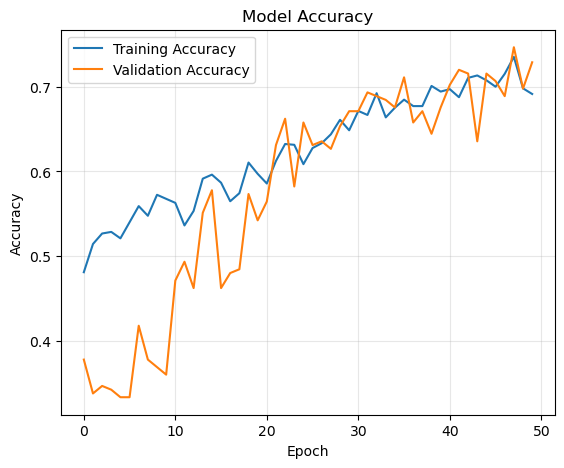

In [12]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

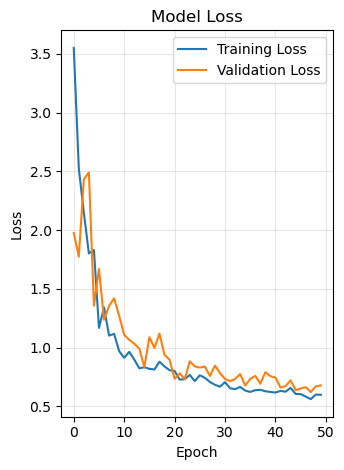

In [13]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'training_history.png'))
plt.show()

In [14]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print("\n" + "="*70)
print("FINAL TEST RESULTS")
print("="*70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("="*70)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - accuracy: 0.7124 - loss: 0.6180

FINAL TEST RESULTS
Test Loss: 0.6180
Test Accuracy: 0.7124 (71.24%)


In [15]:

final_model_path = os.path.join(model_save_dir, 'animal_classifier_final.h5')
model.save(final_model_path)

print(f"✓ Model saved to: {final_model_path}")

✓ Model saved to: /home/gio/Documents/machine_learning/animal_classifier/PetImages/models/animal_classifier_final.h5
